In [1]:
import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import face_recognition
from collections import defaultdict
from imutils.video import VideoStream
import numpy as np
from scipy.ndimage import imread
from scipy.misc import imresize, imsave

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.callbacks import (
    TensorBoard,
    ModelCheckpoint,
    EarlyStopping)
from keras.optimizers import Adam

%matplotlib inline

Using TensorFlow backend.


In [2]:
IMG_SIZE = 24
eyes_path = Path('/home/bob/apps/face_recognition/data/images')
tsb_path = Path('/home/bob/apps/face_recognition/tsb')
checkpoints_path = Path('/home/bob/apps/face_recognition/checkpoints')
face_imgs_basepath = Path('/home/bob/apps/face_recognition/data/face_imgs')
xml_models_basepath = Path('/home/bob/apps/face_recognition/xml_models')

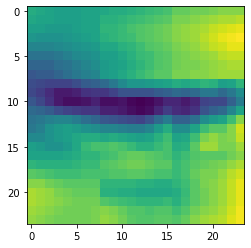

In [3]:
img = cv2.imread(str(eyes_path/Path('closed/closed_eye_0001.jpg_face_1_L.jpg')),
                 cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [4]:
def process_and_encode(images):
    """
    Creates encodings of images of the persons I want to recognize
    """
    known_encodings = []
    known_names = []
    print("[LOG] Encoding dataset ...")

    for image_path in tqdm(images):
        # Load image
        image = cv2.imread(image_path)
        # Convert it from BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
     
        # detect face in the image and get its location (square boxes coordinates)
        boxes = face_recognition.face_locations(image, model='hog')

        # Encode the face into a 128-d embeddings vector
        encoding = face_recognition.face_encodings(image, boxes)

        # the person's name is the name of the folder where the image comes from
        name = image_path.split('/')
        name = name[-1].split('_')
        name = name[0]

        if len(encoding) > 0 : 
            known_encodings.append(encoding[0])
            known_names.append(name)

    return {"encodings": known_encodings, "names": known_names}

In [5]:
# Get imgs path
imgs_list = list(face_imgs_basepath.glob('*'))
imgs_list = [str(path) for path in imgs_list]
imgs_list = sorted(imgs_list)
encoding_dict = process_and_encode(imgs_list)

[LOG] Encoding dataset ...


In [6]:
# Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split=0.1)

In [7]:
train_generator = train_datagen.flow_from_directory(
                    directory=str(eyes_path),
                    target_size=(IMG_SIZE, IMG_SIZE),
                    color_mode='grayscale',
                    classes=['opened', 'closed'],
                    class_mode='binary',
                    subset='training',
                    batch_size=32)

val_generator = train_datagen.flow_from_directory(
                    directory=str(eyes_path),
                    target_size=(IMG_SIZE, IMG_SIZE),
                    color_mode='grayscale',
                    classes=['opened', 'closed'],
                    class_mode='binary',
                    subset='validation',
                    batch_size=32)

Found 4362 images belonging to 2 classes.
Found 484 images belonging to 2 classes.


In [8]:
def train(train_generator, val_generator, optimizer):
    model = Sequential()

    model.add(Conv2D(filters=6,
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(IMG_SIZE,IMG_SIZE,1)))
    model.add(AveragePooling2D())

    model.add(Conv2D(filters=16,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(AveragePooling2D())

    model.add(Flatten())

    model.add(Dense(units=120,
                    activation='relu'))

    model.add(Dense(units=84,
                    activation='relu'))

    model.add(Dense(units=1,
                    activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
  
    print(model.summary())
  
    return model

In [9]:
tsb = TensorBoard(log_dir=str(tsb_path/Path('20190609_tsb01')))

mc = ModelCheckpoint(filepath=str(checkpoints_path/Path('20190609_best01')),
                     monitor='val_loss',
                     verbose=1,
                     save_best_only=True,
                     save_weights_only=True,
                     period=10)

es = EarlyStopping(monitor='val_loss',
                   patience=50,
                   verbose=1)
callbacks = [tsb, mc, es]

In [10]:
adam = Adam(lr=0.0003)
model = train(train_generator, val_generator, adam)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 22, 6)         60        
_________________________________________________________________
average_pooling2d_1 (Average (None, 11, 11, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 16)          880       
_________________________________________________________________
average_pooling2d_2 (Average (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               30840     
_________________________________________________________________
dense_2 (Dense)              (None, 84)                10164     
__________

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=200,
                    callbacks=callbacks)

In [11]:
model.load_weights(str(checkpoints_path/Path('20190609_best01')))

In [12]:
def isBlinking(history, maxFrames):
    """ @history: A string containing the history of eyes status 
         where a '1' means that the eyes were closed and '0' open.
        @maxFrames: The maximal number of successive frames where an eye is closed """
    for i in range(maxFrames):
        pattern = '1' + '0'*(i+1) + '1'
        if pattern in history:
            return True
    return False

In [13]:
def detect_and_display(model, video_capture, face_detector, open_eyes_detector, left_eye_detector, right_eye_detector, data, eyes_detected):
        frame = video_capture.read()
        # resize the frame
        frame = cv2.resize(frame, (0, 0), fx=0.6, fy=0.6)

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Detect faces
        faces = face_detector.detectMultiScale(
            gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(50, 50),
            flags=cv2.CASCADE_SCALE_IMAGE
        )

        # for each detected face
        for (x,y,w,h) in faces:
            # Encode the face into a 128-d embeddings vector
            encoding = face_recognition.face_encodings(rgb, [(y, x+w, y+h, x)])[0]

            # Compare the vector with all known faces encodings
            matches = face_recognition.compare_faces(data["encodings"], encoding)

            # For now we don't know the person name
            name = "Unknown"

            # If there is at least one match:
            if True in matches:
                matchedIdxs = [i for (i, b) in enumerate(matches) if b]
                counts = {}
                for i in matchedIdxs:
                    name = data["names"][i]
                    counts[name] = counts.get(name, 0) + 1

                # The known encoding with the most number of matches corresponds to the detected face name
                name = max(counts, key=counts.get)

            face = frame[y:y+h,x:x+w]
            gray_face = gray[y:y+h,x:x+w]

            eyes = []
            
            # Eyes detection
            # check first if eyes are open (with glasses taking into account)
            open_eyes_glasses = open_eyes_detector.detectMultiScale(
                gray_face,
                scaleFactor=1.1,
                minNeighbors=5,
                minSize=(30, 30),
                flags = cv2.CASCADE_SCALE_IMAGE
            )
            # if open_eyes_glasses detect eyes then they are open 
            if len(open_eyes_glasses) == 2:
                eyes_detected[name]+='1'
                for (ex,ey,ew,eh) in open_eyes_glasses:
                    cv2.rectangle(face,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
            
            # otherwise try detecting eyes using left and right_eye_detector
            # which can detect open and closed eyes                
            else:
                # separate the face into left and right sides
                left_face = frame[y:y+h, x+int(w/2):x+w]
                left_face_gray = gray[y:y+h, x+int(w/2):x+w]

                right_face = frame[y:y+h, x:x+int(w/2)]
                right_face_gray = gray[y:y+h, x:x+int(w/2)]

                # Detect the left eye
                left_eye = left_eye_detector.detectMultiScale(
                    left_face_gray,
                    scaleFactor=1.1,
                    minNeighbors=5,
                    minSize=(30, 30),
                    flags = cv2.CASCADE_SCALE_IMAGE
                )

                # Detect the right eye
                right_eye = right_eye_detector.detectMultiScale(
                    right_face_gray,
                    scaleFactor=1.1,
                    minNeighbors=5,
                    minSize=(30, 30),
                    flags = cv2.CASCADE_SCALE_IMAGE
                )

                eye_status = '1' # we suppose the eyes are open

                # For each eye check wether the eye is closed.
                # If one is closed we conclude the eyes are closed
                for (ex,ey,ew,eh) in right_eye:
                    color = (0,255,0)
                    pred = predict(right_face[ey:ey+eh,ex:ex+ew],model)
                    if pred == 'closed':
                        eye_status='0'
                        color = (0,0,255)
                    cv2.rectangle(right_face,(ex,ey),(ex+ew,ey+eh),color,2)
                for (ex,ey,ew,eh) in left_eye:
                    color = (0,255,0)
                    pred = predict(left_face[ey:ey+eh,ex:ex+ew],model)
                    if pred == 'closed':
                        eye_status='0'
                        color = (0,0,255)
                    cv2.rectangle(left_face,(ex,ey),(ex+ew,ey+eh),color,2)
                eyes_detected[name] += eye_status

            # Each time, we check if the person has blinked
            # If yes, we display its name
            if isBlinking(eyes_detected[name],3):
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                # Display name
                y = y - 15 if y - 15 > 15 else y + 15
                cv2.putText(frame, name, (x, y), cv2.FONT_HERSHEY_SIMPLEX,0.75, (0, 255, 0), 2)

        return frame

In [14]:
def predict(img, model):
    img = Image.fromarray(img, 'RGB').convert('L')
    img = imresize(img, (IMG_SIZE,IMG_SIZE)).astype('float32')
#     img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img /= 255
    img = img.reshape(1,IMG_SIZE,IMG_SIZE,1)
    prediction = model.predict(img)
    if prediction < 0.1:
        prediction = 'closed'
    elif prediction > 0.9:
        prediction = 'open'
    else:
        prediction = 'idk'
    return prediction

In [15]:
face_detector = cv2.CascadeClassifier(str(xml_models_basepath/Path('haarcascade_frontalface_alt.xml')))
open_eyes_detector = cv2.CascadeClassifier(str(xml_models_basepath/Path('haarcascade_eye_tree_eyeglasses.xml')))
left_eye_detector = cv2.CascadeClassifier(str(xml_models_basepath/Path('haarcascade_lefteye_2splits.xml')))
right_eye_detector = cv2.CascadeClassifier(str(xml_models_basepath/Path('haarcascade_righteye_2splits.xml')))

In [27]:
print("[LOG] Opening webcam ...")
video_capture = VideoStream(src=0).start()
eyes_detected = defaultdict(str)
while True:
    frame = detect_and_display(model, video_capture, face_detector, open_eyes_detector,left_eye_detector,right_eye_detector, encoding_dict, eyes_detected)
    cv2.imshow("Face Liveness Detector", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()
video_capture.stop()

[LOG] Opening webcam ...


/home/bob/anaconda3/envs/face_recognition/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_1/convolution}} = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_1/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_1/kernel/read)]]